In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.x13 import x13_arima_analysis, x13_arima_select_order
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [47]:
df = pd.read_csv("../data/raw_data.csv").rename(columns = {"DATE": "date", "Hard coal consumption per capita [tones]": "consumption"})
df.date = pd.to_datetime(df.date).dt.date

df

,date,consumption
0,1994-07-01,0.076
1,1994-08-01,0.097
2,1994-09-01,0.140
3,1994-10-01,0.213
4,1994-11-01,0.345
...,...,...
313,2020-08-01,0.005
314,2020-09-01,0.009
315,2020-10-01,0.028
316,2020-11-01,0.081


<AxesSubplot:title={'center':'Hard coal consumption per capita [tones]'}, xlabel='date'>

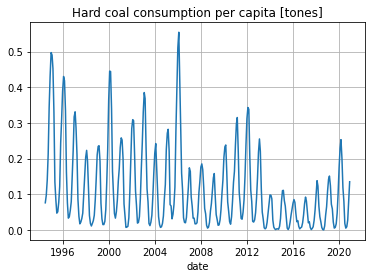

In [48]:
df.plot(x = "date", legend = False, title = "Hard coal consumption per capita [tones]", grid = True)

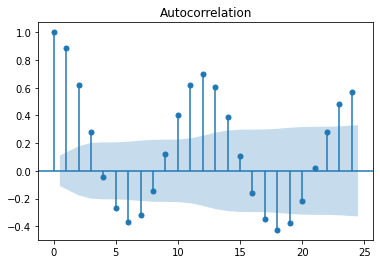

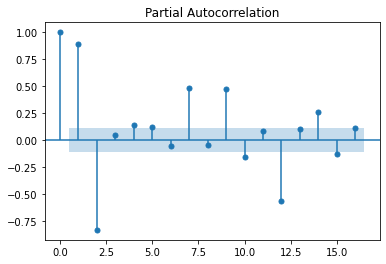

In [45]:
plot_acf(df.consumption, lags=24, alpha=.05, use_vlines=True)
plot_pacf(df.consumption, lags=16, alpha=.05, use_vlines=True)
print()

In [53]:
print(kpss(df.consumption, nlags=12))
print(kpss(df.consumption.diff().dropna(), nlags=12))
print(adfuller(df.consumption, maxlag=12))

(1.1977795261851616, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.056145659823673026, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(-4.150342523447282, 0.0007987112476294385, 12, 305, {'1%': -3.451973573620699, '5%': -2.8710633193086648, '10%': -2.5718441306100512}, -1441.0625563591223)


/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:title={'center':'First differences of hard coal consumption per capita [tones]'}, xlabel='date'>

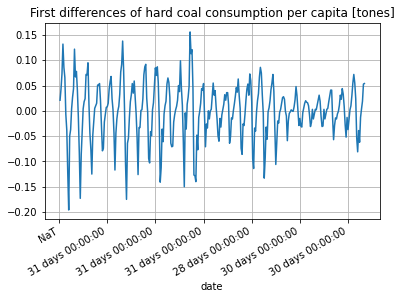

In [56]:
df.diff().plot(x = "date", legend = False, title = "First differences of hard coal consumption per capita [tones]", grid = True)

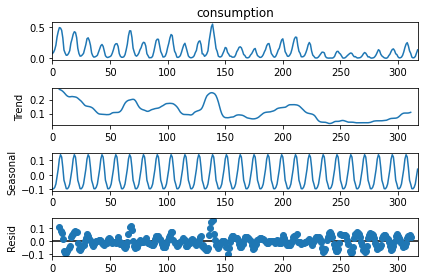

In [60]:
season_decomp_add = seasonal_decompose(df.consumption, model="additive", period=12)
season_decomp_add.plot()

df["resid_ma"] = season_decomp_add.resid.to_numpy()

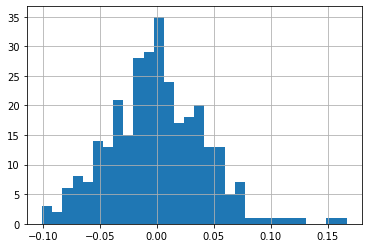

In [61]:
plt.hist(df.resid_ma.dropna().to_numpy(), bins=30)
plt.grid(True)

print()

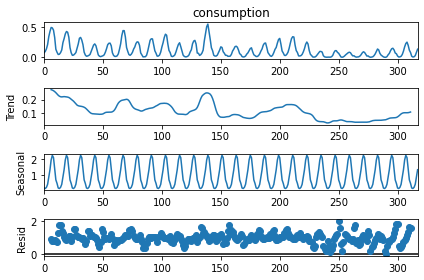

In [62]:
season_decomp_multi = seasonal_decompose(df.consumption + 1e-4, model="multiplicative", period=12)
season_decomp_multi.plot()

df["resid_ma_multi"] = season_decomp_multi.resid.to_numpy()

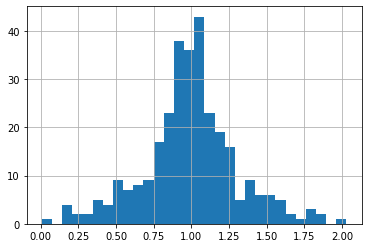

In [63]:
plt.hist(df.resid_ma_multi.dropna().to_numpy(), bins=30)
plt.grid(True)

print()

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([4.06305010e-32, 4.25116191e-35, 4.26188550e-34, 7.32177768e-34,
       1.93260320e-34, 1.12486752e-35, 2.05785432e-36, 3.36850215e-36,
       1.11021600e-35, 4.26733895e-35, 8.39971766e-35, 2.11461496e-36,
       3.40450084e-37, 4.61172869e-37, 1.09439895e-36, 2.68856783e-36,
       9.39417144e-36, 6.14676032e-36, 4.76380517e-37, 7.71225981e-39,
       3.19527584e-40, 6.80536418e-40, 4.51382200e-40, 2.73039284e-42])

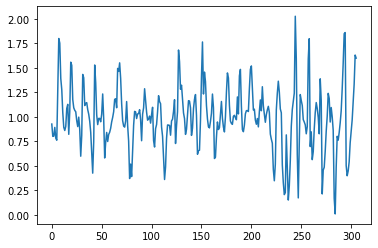

In [71]:
ma_decomp_resid = df.resid_ma.dropna().to_numpy()

plt.plot(ma_decomp_resid)

_, lbox_pval = acorr_ljungbox(ma_decomp_resid, lags=24)
lbox_pval

In [67]:
qmin, qmax = np.quantile(ma_decomp_resid, q=[.03, .97])

df["outlier"] = (df.consumption.values < qmin) | (df.consumption.values > qmax)

df

,date,consumption,resid_ma,resid_ma_multi,outlier
0,1994-07-01,0.076,NaN,NaN,True
1,1994-08-01,0.097,NaN,NaN,True
2,1994-09-01,0.140,NaN,NaN,True
3,1994-10-01,0.213,NaN,NaN,True
4,1994-11-01,0.345,NaN,NaN,True
...,...,...,...,...,...
313,2020-08-01,0.005,NaN,NaN,False
314,2020-09-01,0.009,NaN,NaN,False
315,2020-10-01,0.028,NaN,NaN,False
316,2020-11-01,0.081,NaN,NaN,True


*Further analysis (maybe to be omitted)*

In [ ]:
stl_decomp = STL(df.consumption, period=12, seasonal=7, robust=True).fit()
stl_decomp.plot()

df["resid_stl"] = stl_decomp.resid.to_numpy()

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


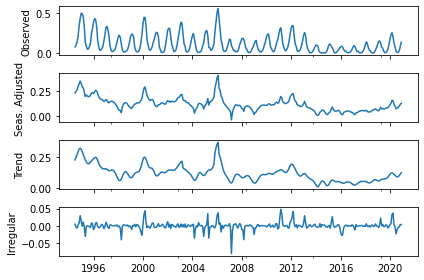

In [37]:
x13_results = x13_arima_analysis(
    pd.Series(df.consumption.values + 1e-4, index=df.date.values),
    maxorder=(2,2),
    maxdiff=(1,1),
    outlier=True,
    forecast_periods=12
)
x13_results.plot()

df["resid_x13"] = x13_results.seasadj.to_numpy()

In [38]:
df.to_csv("../data/data_with_task1_results.csv")

In [39]:
df_stat_test = pd.DataFrame(columns=["var", "test", "diff", "reg", "stat", "pval"])
for var in ["consumption", "resid_ma", "resid_stl", "resid_x13"]:
    for diff in [False, True]:
        for reg in ["c", "ct"]:
            if diff:
                ts = df[var].diff()
            else:
                ts = df[var]

            ts = ts.dropna().to_numpy()
            n = len(df_stat_test)

            stat, pval, _, _ = kpss(ts, nlags=12, regression=reg)
            df_stat_test.loc[n] = [var, "kpss", diff, reg, stat, round(pval, 4)]
            stat, pval, _, _, _, _ = adfuller(ts, maxlag=12, regression=reg)
            df_stat_test.loc[n+1] = [var, "adf", diff, reg, stat, round(pval, 4)]

df_stat_test = df_stat_test.sort_values(["var", "test"])
df_stat_test

/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/jcierocki/.local/share/virtualenvs/jcierocki-E1YtbYr6/lib/python3.9/site-

,var,test,diff,reg,stat,pval
1,consumption,adf,False,c,-4.150343,0.0008
3,consumption,adf,False,ct,-5.129311,0.0001
5,consumption,adf,True,c,-6.217096,0.0000
7,consumption,adf,True,ct,-6.261140,0.0000
0,consumption,kpss,False,c,1.197780,0.0100
2,consumption,kpss,False,ct,0.051329,0.1000
4,consumption,kpss,True,c,0.056146,0.1000
6,consumption,kpss,True,ct,0.055903,0.1000
9,sadj,adf,False,c,-3.196299,0.0202
11,sadj,adf,False,ct,-4.481996,0.0016


In [ ]:
# stl_arima = STLForecast()